# Using Parallel Computing in fmdtools

This notebook will discuss how to use parallel programming in fmdtools, including:
- how to set up a model for parallelism
- syntax for using parallelism in simulation functions
- considerations for optimizing computational performance in a model

In [1]:
from ex_pump import * 
from fmdtools.sim.sample import FaultDomain, FaultSample
import fmdtools.sim.propagate as propagate
import fmdtools.analyze as an

This notebook uses the pump example (see `ex_pump.py`) to illustrate the use of parallelism in fmdtools. This is fairly simple model, and thus it should be noted that there may be considerations with more complex models which may not be adequately covered here.

In [2]:
mdl = Pump()

In [3]:
result, mdlhist = propagate.nominal(mdl, desired_result='graph')

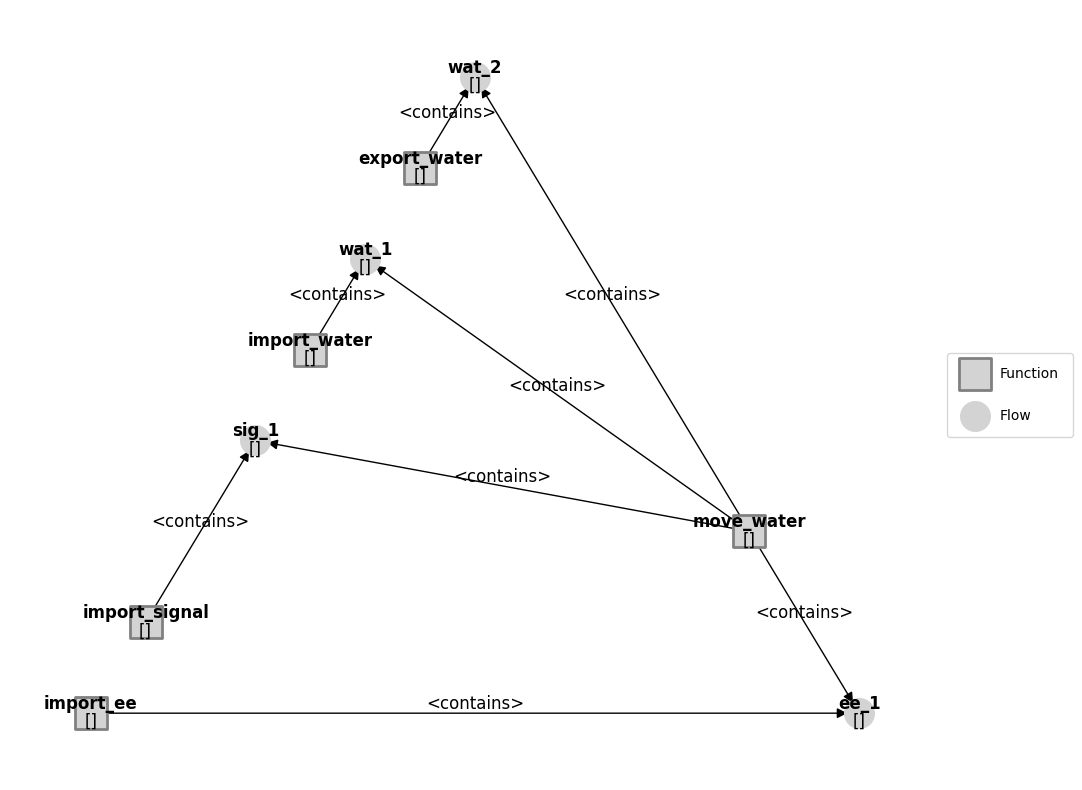

In [4]:
fig, ax = result.graph.draw()

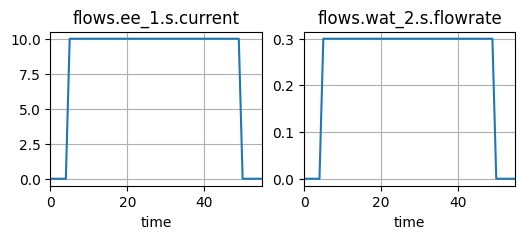

In [5]:
fig, ax = mdlhist.plot_line('flows.ee_1.s.current', 'flows.wat_2.s.flowrate')

## Model Checks

Before attempting to leverage parallelism in model execution, it can be helpful to check whether a model is compatible with python parallel computing libraries. In order for a model to be parallelized, it must be compatible with [pickling](https://docs.python.org/3/library/pickle.html#:~:text=%E2%80%9CPickling%E2%80%9D%20is%20the%20process%20whereby,back%20into%20an%20object%20hierarchy.)--python's method of data serialization. This is used in parallel programming methods to copy the model from the main process thread to the seperate processes of the pool.

fmdtools has two methods to check whether a model can be pickled, `check_pickleability` and `check_model_pickleability`. The main difference between these is that `check_pickleability` works for all objects (e.g. functions and flows), while `check_model_pickleability` gives more information for an overall model structure

In [6]:
from fmdtools.define.object.base import check_pickleability
from fmdtools.define.architecture.base import check_model_pickleability

In [7]:
unpickleable_attributes = check_pickleability(mdl)

The object is pickleable


In [8]:
check_model_pickleability(mdl)

FLOWS 
ee_1
The object is pickleable
sig_1
The object is pickleable
wat_1
The object is pickleable
wat_2
The object is pickleable
FUNCTIONS 
import_ee
ee_out


The object is pickleable
import_water
wat_out


The object is pickleable
import_signal
sig_out
The object is pickleable
move_water
ee_in


sig_in
wat_in


wat_out


The object is pickleable
export_water
wat_in
The object is pickleable


MODEL
The object is pickleable


As you can see, this model is pickleable. However, this may not be the case for all structures if they rely on unpickleable data structures, one common one being iterators like .values().

## Using Parallelism in Simulation

Parallelism generally requires using some external parallel processing toolkit. The syntax used by fmdtools methods is compatible with:
- [multiprocessing](https://docs.python.org/3/library/multiprocessing.html), python's default parallel computing library
- [multiprocess](https://pypi.org/project/multiprocess/), a fork of multiprocessing developed by The UQ Foundation
- [pathos](https://github.com/uqfoundation/pathos), a broader parallel computing package developed by The UQ Foundation

And any other package that emulates multiprocessing.Pool

In [9]:
import multiprocessing as mp
import multiprocess as ms

Parallelism can speed up simulation time when there is a large number of independent simulations to run. The prefered methods for using parallelism are to use a `NominalApproach` or `SampleApproach` with the methods:
- propagate.singlefaults (for all single-fault scenarios in a static model with no approach)
- propagate.approach (for sampling a set of faults)
- propagate.nominal_approach (for simulating the model nominally over a set of parameters)
- propagate.nested_approach (for sampling a set of faults over a set of model parameters)

These methods can be run in parallel by sending them a `pool` object from one of these modules as the optional `pool` argument. Further details on setting up and running an approach are provided in `docs/Approach Use-Cases.ipynb` 

In [10]:
pool = mp.Pool(4)
fd = FaultDomain(mdl)
fd.add_all()
fs = FaultSample(fd)
fs.add_fault_phases()
endclasses, mdlhists = propagate.fault_sample(mdl, fs, pool=pool)
#an.tabulate.simplefmea(endclasses)

SCENARIOS COMPLETE:   0%|          | 0/24 [00:00<?, ?it/s]

SCENARIOS COMPLETE:   4%|▍         | 1/24 [00:01<00:40,  1.75s/it]

SCENARIOS COMPLETE:  71%|███████   | 17/24 [00:01<00:00, 12.42it/s]

SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 12.60it/s]

In [11]:
pool

<multiprocessing.pool.Pool state=TERMINATE pool_size=4>

Sometimes, it helps to "warm up" the pool. See, for example, how much longer per-second iterations take for the above compared to below:

In [12]:
pool = mp.Pool(4)
endclasses, mdlhists = propagate.single_faults(mdl, pool=pool)
#an.tabulate.simplefmea(endclasses)

SCENARIOS COMPLETE:   0%|          | 0/8 [00:00<?, ?it/s]

SCENARIOS COMPLETE:  12%|█▎        | 1/8 [00:01<00:11,  1.58s/it]

SCENARIOS COMPLETE: 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]

It can also be helpful to verify that the results of parallel simulation and normal serial execution are the same:

In [13]:
pool = mp.Pool(4)
endclasses_par, mdlhists = propagate.single_faults(mdl, pool=pool, close_pool=False)
#tab_par = an.tabulate.simplefmea(endclasses_par)
endclasses, mdlhists = propagate.single_faults(mdl)
#tab = an.tabulate.simplefmea(endclasses)
#tab - tab_par

SCENARIOS COMPLETE:   0%|          | 0/8 [00:00<?, ?it/s]

SCENARIOS COMPLETE:  12%|█▎        | 1/8 [00:01<00:11,  1.61s/it]

SCENARIOS COMPLETE: 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]

SCENARIOS COMPLETE:   0%|          | 0/8 [00:00<?, ?it/s]

SCENARIOS COMPLETE:  50%|█████     | 4/8 [00:00<00:00, 38.17it/s]

SCENARIOS COMPLETE: 100%|██████████| 8/8 [00:00<00:00, 38.74it/s]

SCENARIOS COMPLETE: 100%|██████████| 8/8 [00:00<00:00, 38.65it/s]

In [14]:
# pool = mp.Pool(4)
endclasses_par, mdlhists = propagate.fault_sample(mdl, fs, pool=pool)
#tab_par = an.tabulate.simplefmea(endclasses_par)
endclasses, mdlhists = propagate.fault_sample(mdl, fs)
#tab = an.tabulate.simplefmea(endclasses)
#tab - tab_par
pool

SCENARIOS COMPLETE:   0%|          | 0/24 [00:00<?, ?it/s]

SCENARIOS COMPLETE:  50%|█████     | 12/24 [00:00<00:00, 117.46it/s]

SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 125.74it/s]

SCENARIOS COMPLETE:   0%|          | 0/24 [00:00<?, ?it/s]

SCENARIOS COMPLETE:  17%|█▋        | 4/24 [00:00<00:00, 39.93it/s]

SCENARIOS COMPLETE:  33%|███▎      | 8/24 [00:00<00:00, 33.62it/s]

SCENARIOS COMPLETE:  54%|█████▍    | 13/24 [00:00<00:00, 37.30it/s]

SCENARIOS COMPLETE:  75%|███████▌  | 18/24 [00:00<00:00, 39.06it/s]

SCENARIOS COMPLETE:  92%|█████████▏| 22/24 [00:00<00:00, 39.31it/s]

SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 38.55it/s]

<multiprocessing.pool.Pool state=TERMINATE pool_size=4>

While fmdtools built-in methods are the easiest way to leverage parallelism, it can also be used with custom arguments/methods to meet the needs of simulation. However, (on Windows) these methods need to be defined in an external module with an "if __name__=='__main__':" statement, otherwise execution will hang from spawning new processes. This has to do with how multiprocessing works in windows.

To show how parellism can be leveraged manually for a desired use-case, below the model is run over the blockage fault mode at time t=1 with a different model parameter (delayed failure behavior), as defined in the `parallelism_methods.py` module in this folder.

In [15]:
from parallelism_methods import delay_test

In [16]:
results = delay_test()
results

[endclass.rate:                     1e-05
 endclass.cost:        20125.000000000007
 endclass.expected_cost: 20125.000000000007,
 endclass.rate:                     1e-05
 endclass.cost:        20102.500000000007
 endclass.expected_cost: 20102.500000000007,
 endclass.rate:                     1e-05
 endclass.cost:        20080.000000000007
 endclass.expected_cost: 20080.000000000007,
 endclass.rate:                     1e-05
 endclass.cost:        20057.500000000007
 endclass.expected_cost: 20057.500000000007,
 endclass.rate:                     1e-05
 endclass.cost:        20035.000000000007
 endclass.expected_cost: 20035.000000000007,
 endclass.rate:                     1e-05
 endclass.cost:        15023.750000000005
 endclass.expected_cost: 15023.750000000005,
 endclass.rate:                     1e-05
 endclass.cost:        15023.750000000005
 endclass.expected_cost: 15023.750000000005,
 endclass.rate:                     1e-05
 endclass.cost:        15023.750000000005
 endclass.exp

In this method, the model is run many times over a given fault with different delay parameters. It should be noted that this approach is not especially efficient, since the nominal scenario is simulated at each call of `propagate.one_fault()`. It is thus preferred to use the appropriate fault/parameter sampling approaches and propagate methods, since these methods only run the nominal simulation once for fault scenarios and can also use staged execution (copying the model at fault time for fault scenarios) to reduce the cost of each simulation.

## Performance Comparison

Parallelism is often used in computation to speed up up a set of independent simulations. Conventionally, one might say it leads to a reduced computational cost of $t/n$, where t was the original time of the set of processes, and n is the number of cores.

However, this computational performance increase is dependent on the implementation. In Python, there is some overhead from 
from communicating data structures in and out of parallel threads which can become a significant consideration when the data structures are large. Additionally, different Pools can execute more or less efficiently. Below these are each compared.

In [17]:
import matplotlib.pyplot as plt
from parallelism_methods import compare_pools, instantiate_pools, terminate_pools

In [18]:
cores=4
pools = instantiate_pools(cores)

Below is the baseline comparison, where the the following parameters characterize the sampling approach:
 - single faults: only the single-fault scenarios are considered
 - 3 points per phase: an evenly-spaced quadrature is sampled at each phase of operation (start, on, end) for the model
 - staged: the model is copied at each point in time where faults is injected during the model time to save computation
 - track: the entire model history is returned for each simulation
 
 This is typical for a small model like this where the per-model expense is low.

In [19]:
mdl=Pump(track='all')
fs = FaultSample(fd)
fs.add_fault_phases(args = (3,))

pools = instantiate_pools(5)
_ = compare_pools(mdl, fs, pools, staged=True, verbose=False)

C:\Users\dhulse\AppData\Local\anaconda3\lib\multiprocessing\pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=4>
  _warn(f"unclosed running multiprocessing pool {self!r}",
C:\Users\dhulse\AppData\Local\anaconda3\lib\site-packages\multiprocess\pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocess.pool.Pool state=RUN pool_size=4>
  _warn(f"unclosed running multiprocessing pool {self!r}",


In [20]:
exectimes = compare_pools(mdl, fs, pools, staged=True, verbose=False)
exectimes_baseline = exectimes

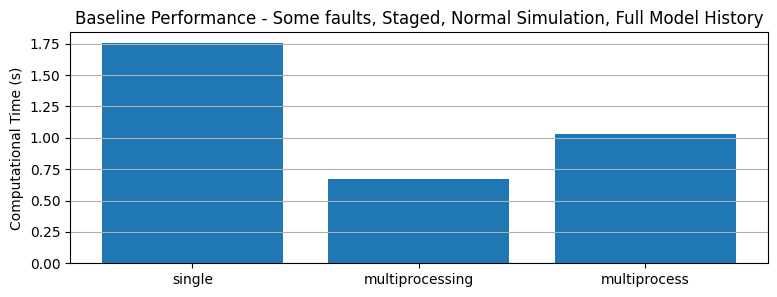

In [21]:
fig = plt.figure(figsize=(9, 3),)
plt.bar(range(len(exectimes)), list(exectimes.values()), align='center')
plt.xticks(range(len(exectimes)), list(exectimes.keys()))
plt.title("Baseline Performance - Some faults, Staged, Normal Simulation, Full Model History")
plt.ylabel("Computational Time (s)")
plt.grid(axis='y')

As shown, in this situation, both the multiprocessing and threadpool pools give computational performance increases.

### Comparison: No Histories

In the below comparison, the same simulation approach is run, except without tracking a history of model states through the simulation.

In [22]:
mdl=Pump(track='none')
exectimes = compare_pools(mdl, fs, pools, staged=True, verbose=False)

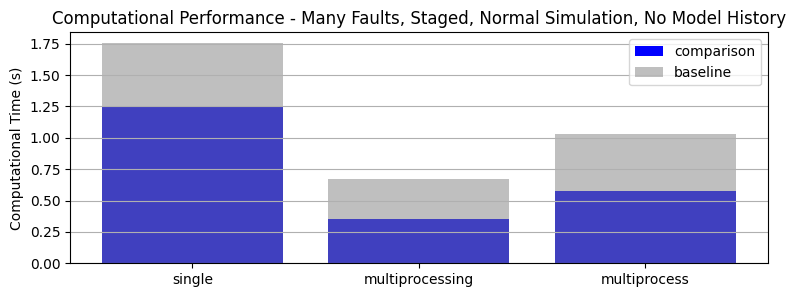

In [23]:
fig = plt.figure(figsize=(9, 3),)
width = 0.8
plt.bar(range(len(exectimes)), list(exectimes.values()), align='center', color="blue", label="comparison")
plt.bar(range(len(exectimes_baseline)), list(exectimes_baseline.values()), align='center', color="gray", alpha=0.5, label="baseline")
plt.xticks(range(len(exectimes)), list(exectimes.keys()))
plt.title("Computational Performance - Many Faults, Staged, Normal Simulation, No Model History")
plt.ylabel("Computational Time (s)")
plt.grid(axis='y')
plt.legend()

As shown, in this situation, the overall simulation expense decreases, even in the serial execution case.

Additionally, the case for using a parallel processing pool increases somewhat. This is because passing the model history back to the main process is nearly comparable in time to simulation itself.

As a result, removing it saves a large amount of computational time when using parallel processing.

### Comparison: Many Faults

In the below comparison, many faults are injected in the system to increase the number of scenarios (ostensibly making the case better for parallelism)

In [24]:
fs_many = FaultSample(fd)
fs_many.add_fault_phases(args = (7,))
mdl=Pump(track='all')
exectimes = compare_pools(mdl, fs_many, pools, staged=True, verbose=False)

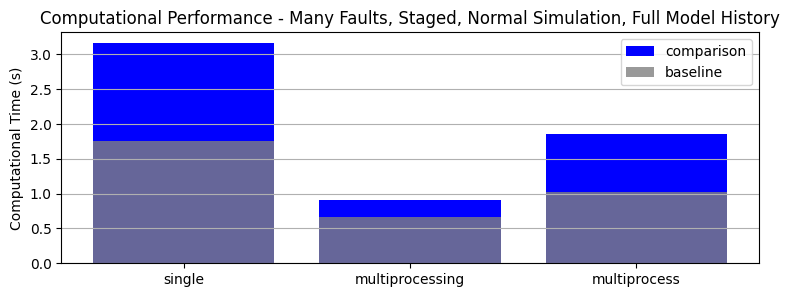

In [25]:
fig = plt.figure(figsize=(9, 3),)
width = 0.8
plt.bar(range(len(exectimes)), list(exectimes.values()), align='center', color="blue", label="comparison")
plt.bar(range(len(exectimes_baseline)), list(exectimes_baseline.values()), align='center', color="gray", alpha=0.8, label="baseline")
plt.xticks(range(len(exectimes)), list(exectimes.keys()))
plt.title("Computational Performance - Many Faults, Staged, Normal Simulation, Full Model History")
plt.ylabel("Computational Time (s)")
plt.grid(axis='y')
plt.legend()

As shown, increasing the number of joint-fault scenarios increases computational costs significantly--as would be expected.

In this situation, multiprocessing performs comparatively better, but only slightly--instead of taking 1/4 the time, it only takes about 1/2 the time.

### Comparison: Long simulation

It may be of interest to simulate how the comparative performance changes for longer simulations. In this comparison, the simulation time is extended tenfold.

In [26]:
mdl=Pump(sp=dict(times=(0,20, 500)), track='all')
exectimes = compare_pools(mdl, fs, pools, staged=True, verbose=False)

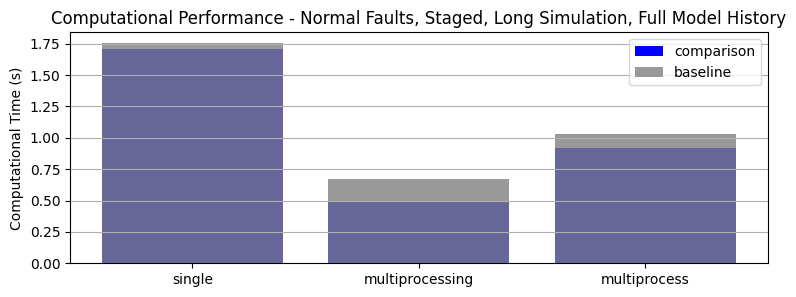

In [27]:
fig = plt.figure(figsize=(9, 3),)
width = 0.8
plt.bar(range(len(exectimes)), list(exectimes.values()), align='center', color="blue", label="comparison")
plt.bar(range(len(exectimes_baseline)), list(exectimes_baseline.values()), align='center', color="gray", alpha=0.8, label="baseline")
plt.xticks(range(len(exectimes)), list(exectimes.keys()))
plt.title("Computational Performance - Normal Faults, Staged, Long Simulation, Full Model History")
plt.ylabel("Computational Time (s)")
plt.grid(axis='y')
plt.legend()

As shown, the simulation time does increase significantly--about tenfold. In terms of comparative performance, pools other than multiprocessing now become competitive, though multiprocessing is still the fastest overall. 

This shows the main case for using parallesism--speeding up long simulations. Short simulations unfortunately require a significant amount of overhead due to copying in and out of the individual thread and we thus see less of a case for them there.

### Comparison: Long Simulation No Tracking

Finally, it may be interesting to see how performance is affected in long simulations when there is no tracking. This is because in these simulations, there should be very little overhead from creating the respective data structures, even when there is a long simulation. This comparison is shown below.

In [28]:
mdl=Pump(sp=dict(times=(0,20, 500)), track='none')
exectimes = compare_pools(mdl, fs, pools, staged=True, verbose=False)

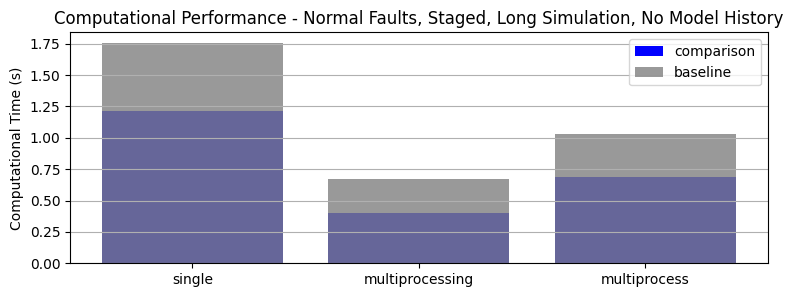

In [29]:
fig = plt.figure(figsize=(9, 3),)
width = 0.8
plt.bar(range(len(exectimes)), list(exectimes.values()), align='center', color="blue", label="comparison")
plt.bar(range(len(exectimes_baseline)), list(exectimes_baseline.values()), align='center', color="gray", alpha=0.8, label="baseline")
plt.xticks(range(len(exectimes)), list(exectimes.keys()))
plt.title("Computational Performance - Normal Faults, Staged, Long Simulation, No Model History")
plt.ylabel("Computational Time (s)")
plt.grid(axis='y')
plt.legend()

As shown, removing the tracking makes the long simulations much take less time than the short simulation!

### Comparison: Long Simulation Only Necessary Tracking

In practice, it can be necessary to track some states over time. Here we perform the same comparison using the 'valstates' option, which only tracks states which have been defined in the model to be necessary to track (using 'valparams')

In [30]:
mdl=Pump(sp=dict(times=(0,20, 500))) # see default track for Pump
exectimes = compare_pools(mdl, fs, pools, staged=True, verbose=False)

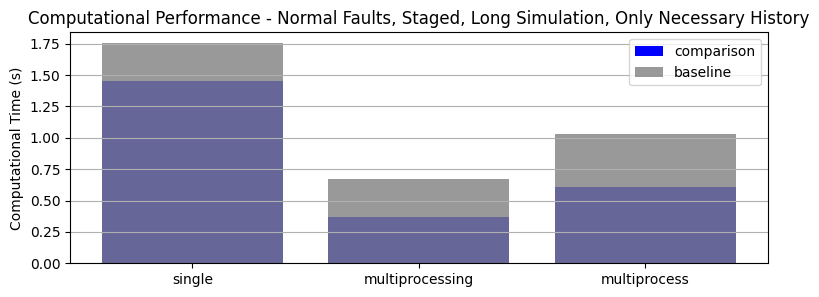

In [31]:
fig = plt.figure(figsize=(9, 3),)
width = 0.8
plt.bar(range(len(exectimes)), list(exectimes.values()), align='center', color="blue", label="comparison")
plt.bar(range(len(exectimes_baseline)), list(exectimes_baseline.values()), align='center', color="gray", alpha=0.8, label="baseline")
plt.xticks(range(len(exectimes)), list(exectimes.keys()))
plt.title("Computational Performance - Normal Faults, Staged, Long Simulation, Only Necessary History")
plt.ylabel("Computational Time (s)")
plt.grid(axis='y')
plt.legend()

As shown, only tracking a few variables results in similar computational time no tracking.

This is because a major computational performance limitation in this model is not necessarily the model simulation itself, but the generation, update, and passing of the history. So it is often best to only track necessary parameters when possible, rather than the entire model history.

## Comparison: Lower Tracking Time Resolution

Finally, the number of recorded timesteps can be lowered to lower computational costs while still returning all relevant variables.

In [32]:
mdl=Pump(sp=dict(times=(0,20, 500), track_times=("interval", 5)), track='all')
exectimes = compare_pools(mdl, fs, pools, staged=True, verbose=False)

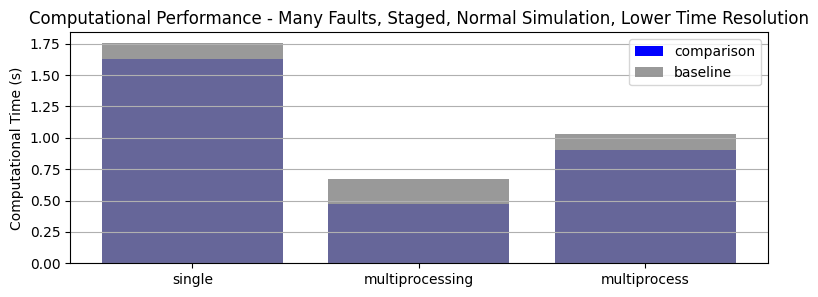

In [33]:
fig = plt.figure(figsize=(9, 3),)
width = 0.8
plt.bar(range(len(exectimes)), list(exectimes.values()), align='center', color="blue", label="comparison")
plt.bar(range(len(exectimes_baseline)), list(exectimes_baseline.values()), align='center', color="gray", alpha=0.8, label="baseline")
plt.xticks(range(len(exectimes)), list(exectimes.keys()))
plt.title("Computational Performance - Many Faults, Staged, Normal Simulation, Lower Time Resolution")
plt.ylabel("Computational Time (s)")
plt.grid(axis='y')
plt.legend()

As shown, while lowering time resolution could theoretically lower computational time, it does not significantly change much in this example. 

In [34]:
terminate_pools(pools)

## Comparison Conclusions:

Parallelism can the improve computational performance of a given resilience simulation approach. However, this improvement is dependent on the parameters of the simulation. Generally, the official python `multiprocessing` module seems consistently give the best performance improvement over a single-process execution, although this can change depending on the underlying model and modelling approach. There are additionally reasons you might choose other pools-- `multiprocess` pools may enable more data structures in the model because they extend what can be communicated in and out of threads.

In general, one of the major considerations for optimization compuational time is not just the *simulation of the model*, but the *size of the returned data structures*. Minimizing the size of the returned data structures can reduce computational time both by reducing the time of an individual simulation and by reducing the *parallelism overhead* from copying these data structures in and out of parallel threads. However, it is important to recognize that for resilience assessment, one often needs a history of model states (or, at least, states of interest) to properly quantify the dynamic costs (i.e., $\int C_f(t) dt$). Indeed, in this model, only repair costs were able to be used in the comparison of non-tracked states, because the other dynamic costs required a history of their corresponding flows. Changing the number and size of tracked model states can influence the computational time, but only to a point--while one would expect lowering time-fidelity to have a significant effect, it does not because the overhead is less to do with filling the underlying data structures as it has to do with instantiating and returning them--a far more effective method is to only return the functions/flows which are needed by the model.

## Further Computational Cost Reduction via Profiling
While parallelism and staged execution are helpful and relatively easy-to-implement methods of computational cost reduction, it can be helpful (especially for more complex models) to see what aspects of the model are taking the most computational time.

While staged execution was not explored here, it can make a difference when faults are to be injected near the end of the simulation by making it unnecessary to simulate up to the fault time. However, it is less helpful when model instantiation/copy time is a significant fraction of simulation time.

Python's builtin `cProfile` package can ge used to see the relative computational times of different functions/processes.

In [35]:
import cProfile

In [36]:
mdl=Pump(sp=dict(track='all'))
prof = cProfile.run('propagate.nominal(mdl)', sort='tottime')

         72852 function calls (72428 primitive calls) in 0.037 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2268    0.003    0.000    0.004    0.000 base.py:395(<listcomp>)
       56    0.002    0.000    0.025    0.000 function.py:403(prop_static)
     1124    0.002    0.000    0.002    0.000 base.py:374(<listcomp>)
     1124    0.002    0.000    0.006    0.000 base.py:406(get_all_roles)
     1124    0.002    0.000    0.005    0.000 base.py:388(<listcomp>)
      562    0.002    0.000    0.007    0.000 function.py:136(__call__)
     1124    0.001    0.000    0.002    0.000 time.py:96(return_mutables)
     2268    0.001    0.000    0.005    0.000 base.py:391(get_roles)
    10668    0.001    0.000    0.001    0.000 {built-in method builtins.getattr}
       50    0.001    0.000    0.001    0.000 base.py:194(<listcomp>)
       72    0.001    0.000    0.001    0.000 {built-in method builtins.dir}
     1124    0.001    0.0

In [37]:
prof = cProfile.run('propagate.fault_sample(mdl, fs)', sort='tottime')

SCENARIOS COMPLETE:   0%|          | 0/72 [00:00<?, ?it/s]

SCENARIOS COMPLETE:   4%|▍         | 3/72 [00:00<00:02, 29.99it/s]

SCENARIOS COMPLETE:   8%|▊         | 6/72 [00:00<00:02, 26.88it/s]

SCENARIOS COMPLETE:  12%|█▎        | 9/72 [00:00<00:02, 27.05it/s]

SCENARIOS COMPLETE:  17%|█▋        | 12/72 [00:00<00:02, 28.13it/s]

SCENARIOS COMPLETE:  22%|██▏       | 16/72 [00:00<00:01, 28.33it/s]

SCENARIOS COMPLETE:  26%|██▋       | 19/72 [00:00<00:01, 28.81it/s]

SCENARIOS COMPLETE:  31%|███       | 22/72 [00:00<00:01, 28.06it/s]

SCENARIOS COMPLETE:  35%|███▍      | 25/72 [00:00<00:01, 27.68it/s]

SCENARIOS COMPLETE:  39%|███▉      | 28/72 [00:01<00:01, 27.93it/s]

SCENARIOS COMPLETE:  43%|████▎     | 31/72 [00:01<00:01, 28.15it/s]

SCENARIOS COMPLETE:  47%|████▋     | 34/72 [00:01<00:01, 27.78it/s]

SCENARIOS COMPLETE:  51%|█████▏    | 37/72 [00:01<00:01, 28.06it/s]

SCENARIOS COMPLETE:  56%|█████▌    | 40/72 [00:01<00:01, 27.85it/s]

SCENARIOS COMPLETE:  60%|█████▉    | 43/72 [00:01<00:01, 28.06it/s]

SCENARIOS COMPLETE:  64%|██████▍   | 46/72 [00:01<00:00, 28.20it/s]

SCENARIOS COMPLETE:  68%|██████▊   | 49/72 [00:01<00:00, 28.32it/s]

SCENARIOS COMPLETE:  72%|███████▏  | 52/72 [00:01<00:00, 28.40it/s]

SCENARIOS COMPLETE:  78%|███████▊  | 56/72 [00:01<00:00, 28.84it/s]

SCENARIOS COMPLETE:  83%|████████▎ | 60/72 [00:02<00:00, 29.11it/s]

SCENARIOS COMPLETE:  88%|████████▊ | 63/72 [00:02<00:00, 27.90it/s]

SCENARIOS COMPLETE:  92%|█████████▏| 66/72 [00:02<00:00, 27.63it/s]

SCENARIOS COMPLETE:  96%|█████████▌| 69/72 [00:02<00:00, 27.48it/s]

SCENARIOS COMPLETE: 100%|██████████| 72/72 [00:02<00:00, 27.11it/s]

SCENARIOS COMPLETE: 100%|██████████| 72/72 [00:02<00:00, 27.91it/s]

         4736681 function calls (4708317 primitive calls) in 2.621 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   165096    0.241    0.000    0.289    0.000 base.py:395(<listcomp>)
     4088    0.172    0.000    1.994    0.000 function.py:403(prop_static)
    82106    0.134    0.000    0.496    0.000 base.py:406(get_all_roles)
    82106    0.132    0.000    0.156    0.000 base.py:374(<listcomp>)
    82106    0.131    0.000    0.417    0.000 base.py:388(<listcomp>)
    41125    0.128    0.000    0.544    0.000 function.py:136(__call__)
    82106    0.113    0.000    0.137    0.000 time.py:96(return_mutables)
   165096    0.102    0.000    0.391    0.000 base.py:391(get_roles)
   751841    0.086    0.000    0.086    0.000 {built-in method builtins.getattr}
    82106    0.075    0.000    0.727    0.000 base.py:372(find_mutables)
    82106    0.074    0.000    1.218    0.000 base.py:377(return_mutables)
     4088    0.064  

In [38]:
prof = cProfile.run('propagate.fault_sample(mdl, fs)', sort='cumtime')

SCENARIOS COMPLETE:   0%|          | 0/72 [00:00<?, ?it/s]

SCENARIOS COMPLETE:   4%|▍         | 3/72 [00:00<00:02, 25.52it/s]

SCENARIOS COMPLETE:   8%|▊         | 6/72 [00:00<00:02, 26.47it/s]

SCENARIOS COMPLETE:  12%|█▎        | 9/72 [00:00<00:02, 26.54it/s]

SCENARIOS COMPLETE:  17%|█▋        | 12/72 [00:00<00:02, 27.08it/s]

SCENARIOS COMPLETE:  21%|██        | 15/72 [00:00<00:02, 27.17it/s]

SCENARIOS COMPLETE:  25%|██▌       | 18/72 [00:00<00:01, 28.06it/s]

SCENARIOS COMPLETE:  29%|██▉       | 21/72 [00:00<00:01, 27.66it/s]

SCENARIOS COMPLETE:  33%|███▎      | 24/72 [00:00<00:01, 27.20it/s]

SCENARIOS COMPLETE:  38%|███▊      | 27/72 [00:00<00:01, 27.69it/s]

SCENARIOS COMPLETE:  42%|████▏     | 30/72 [00:01<00:01, 27.46it/s]

SCENARIOS COMPLETE:  46%|████▌     | 33/72 [00:01<00:01, 28.15it/s]

SCENARIOS COMPLETE:  50%|█████     | 36/72 [00:01<00:01, 28.01it/s]

SCENARIOS COMPLETE:  54%|█████▍    | 39/72 [00:01<00:01, 27.79it/s]

SCENARIOS COMPLETE:  60%|█████▉    | 43/72 [00:01<00:01, 28.44it/s]

SCENARIOS COMPLETE:  64%|██████▍   | 46/72 [00:01<00:00, 28.09it/s]

SCENARIOS COMPLETE:  69%|██████▉   | 50/72 [00:01<00:00, 28.60it/s]

SCENARIOS COMPLETE:  74%|███████▎  | 53/72 [00:01<00:00, 28.59it/s]

SCENARIOS COMPLETE:  78%|███████▊  | 56/72 [00:02<00:00, 28.59it/s]

SCENARIOS COMPLETE:  82%|████████▏ | 59/72 [00:02<00:00, 28.21it/s]

SCENARIOS COMPLETE:  88%|████████▊ | 63/72 [00:02<00:00, 28.70it/s]

SCENARIOS COMPLETE:  93%|█████████▎| 67/72 [00:02<00:00, 29.00it/s]

SCENARIOS COMPLETE:  99%|█████████▊| 71/72 [00:02<00:00, 29.20it/s]

SCENARIOS COMPLETE: 100%|██████████| 72/72 [00:02<00:00, 28.15it/s]

         4736406 function calls (4708042 primitive calls) in 2.612 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.612    2.612 {built-in method builtins.exec}
        1    0.000    0.000    2.612    2.612 <string>:1(<module>)
        1    0.000    0.000    2.612    2.612 propagate.py:571(fault_sample)
        1    0.001    0.001    2.559    2.559 propagate.py:760(scenlist_helper)
       73    0.016    0.000    2.236    0.031 propagate.py:1032(prop_one_scen)
       72    0.000    0.000    2.204    0.031 propagate.py:809(exec_scen)
     4088    0.012    0.000    2.020    0.000 function.py:366(propagate)
     4088    0.171    0.000    1.981    0.000 function.py:403(prop_static)
    82106    0.073    0.000    1.213    0.000 base.py:377(return_mutables)
    82106    0.073    0.000    0.725    0.000 base.py:372(find_mutables)
    41125    0.125    0.000    0.538    0.000 function.py:136(__call_

In [39]:
prof = cProfile.run('Pump()', sort='tottime')

         7891 function calls (7870 primitive calls) in 0.004 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       25    0.001    0.000    0.001    0.000 base.py:194(<listcomp>)
       36    0.001    0.000    0.001    0.000 {built-in method builtins.dir}
     3551    0.000    0.000    0.000    0.000 {method 'startswith' of 'str' objects}
       11    0.000    0.000    0.000    0.000 base.py:318(<listcomp>)
       20    0.000    0.000    0.003    0.000 base.py:197(init_roles)
       14    0.000    0.000    0.000    0.000 inspect.py:2279(_signature_from_function)
       74    0.000    0.000    0.000    0.000 inspect.py:2636(__init__)
       28    0.000    0.000    0.000    0.000 inspect.py:2919(__init__)
    28/14    0.000    0.000    0.001    0.000 inspect.py:2374(_signature_from_callable)
       12    0.000    0.000    0.001    0.000 parameter.py:50(__init__)
       12    0.000    0.000    0.000    0.000 inspect.py:3205(__

As shown, running this model is not particularly computationally expensive. As a result, the majority of the computational expense is not actually because of the simulation itself, but because of the way the model is simulated:
- the majority is spent simulating the model
- a certain amount is spent re-initalizing the model at first so that the model object can be re-used without worrying about it being modified by any previous executions 
- another amount is spent recording the model history, wich can increase or decrease depending on tracking options (note the low number of values tracked in the pump model by default)



This is mostly because the model itself is computationally inexpensive. However, this example shows how one might easily speed up simulation for optimization or large-n simulations--avoiding unnecessary re-initialization, tracking fewer model states, or speeding up model execution. This can be done in the following ways:
- using the options for `track` (as mentioned above) to track fewer states (reducing time spent recording the history)
- using `protect` options, which specifies whether the model used is re-instantiated for the simulation (`True`) or used directly (`False`)
- speeding up the model by using `dynamic_behavior()` methods instead of `static_behavior()` or `behavior()` methods (which can halve the simulation time at the expense of undirected propagation)
- speeding up the model by using a longer global timestep (`'tstep'` in `modelparams`) or by speeding up paricularly expensive Function dynamic behaviors by setting (`dt=local_tstep`) in the `SimParam`